## Lab 04 -- Web scraping

So far in this course we have dealt with data which has been collected by someone else and has appeared in a neat, nice format. Unfortunately a good deal of data doesn't appear to us in a clean format. we have to wrestle with the data so that it's in a nice format for us to analyze. This is where web scraping and APIs come into play.

*Web scraping* is the process of accessing unstructured or semi-structured data which is on the web and turning it into data we can use, i.e. a structured dataset.

In this course we are going to focus on two types of web scraping: screen scraping and APIs (or Application Programming Interfaces). Screen scraping is a technique for extracting data from the source code of the website. APIs, on the other hand, are a service which is provided by a company or organization with the intent of delivering data to some end user. We'll talk about APIs next week.

Because bandwidth is expensive and making automated hits to a website may "[clog up](https://en.wikipedia.org/wiki/Denial-of-service_attack) the [tubes](https://www.youtube.com/watch?v=f99PcP0aFNE)", we need to have to some rules for accessing sites and APIs. If you're interested in a particular site, check to see if an API is available. For instance, we could collect Twitter data by going to twitter.com and saving the website to a file. Or we could use [Twitter's API](dev.twitter.com) for collecting tweets. Second, try to limit your bandwidth usage. It's helpful to do this by only accessing the site once, then saving the HTML to disk. Lastly, pay attention to rate limits and terms of service. We'll discuss much of this below.

## Screen scraping

The basic language which has underlied the web for the past few decades is HTML, or HyperText Markup Language. Several of you in this course have worked with HTML, so this shouldn't be new to you. Supplementing HTML more recently is CSS, or Cascading Style Sheets. There's also JavaScript, but we will not talk much about that today.

The first thing about screen scraping we need to know the structure of the web page we want to scrape. All web pages follow a basic structure of *elements*. Elements are *nested* within each other, which means that elements can fit inside of other elements. 

![](img/page_structure_example.jpg)

Above image from [this site](https://alleasytricks.files.wordpress.com/2015/02/page_structure_example.jpg).

In the example above, the element at the top (also called the *root* element) is <code>html</code>. Within that, there's a number of other elemnts which contain information which might be helpful for us. Usually, when we are screen scraping for social data, we want to get some text elements. In the image above, those elements with text data are <code>title</code>, <code>h1</code>, and the two <code>p</code> elements. Those are all HTML *tags*. But we can also access elements by CSS attributes. Most importantly, we can access elements by the CSS attributes <code>class</code> and <code>id</code>.

From here, let's split the kinds of task of screen scraping into two types of tasks depending on our data format: table format and unstructured format.

### Screen scraping in table format

Lots of the data which we want to collect is already in format which looks like a Data Frame. Tables are a common part of the structure of many websites, so there's a set of common methods for collecting them.

Let's take a look at a website which has many tables: Wikipedia. In particular, let's look at the Wikipedia site for the [List of census metropolitan areas and agglomerations in Canada](https://en.wikipedia.org/wiki/List_of_census_metropolitan_areas_and_agglomerations_in_Canada). The table on this site looks like this.

![](img/top-100-cities.png)

There's a number of columns which would be relevant for statistical analyses, including population rank in 2006 and 2011, population in those years, and the change in population between those years. There's also province and geographic name.

Once we've identified our table, we need to find a way to collect it. We can do this by identifying which HTML tags and CSS attributes identify this table. To do this, we can use the "Inspect" or "View Source" feature in our web browsers. On my computer (my Mac, using Google Chrome), I have an "Inspect" option. This will probably look different on the lab computers and also depend on the browser you're using.

![](img/chrome-inspect.png)

Once you click "Inspect" or "View Source", you'll get something that looks like the screenshot below. Tools like the Chrome inspect are nice because they allow you to see the HTML element and then it also visually selects the element on the screen. 

![](img/inspect-selected.png)

It will be useful here to highlight the HTML elements we are looking for in the table, and what CSS attributes we use.

For any HTML table, there are several necessary parts. The <code>&lt;table&gt;</code> tag declares that there's going to be a table here. The <code>&lt;tr&gt;</code> tag declares that there is going to be a row. The <code>&lt;th&gt;</code> and <code>&lt;td&gt;</code> tags are similar: they both denote that this is a cell of the table. However, the <code>&lt;th&gt;</code> tag is a header cell while <code>&lt;td&gt;</code> is any other cell in the table.

    <table>
        <tr>
            <th>Header1</th><th>Header2</th>
        </tr>
        <tr>
            <td>Data1</td><td>Data2</td>
        </tr>
        <!-- ... more rows here ... -->
    </table>

We also note that there's two CSS attributes of importance above: <code>class</code> and <code>id</code>. An HTML element can take on an virtually unlimited number of classes, while an HTML element can only have one ID and it should unique to the webpage.

In this case, the Wikipedia table here has no <code>id</code>, but it has three classes: <code>wikitable, sortable,</code> and <code>jquery-tablesorter</code>.

Okay, now that we have gone through the HTML, we need to actually collect the data.

First, we need to import a few important modules. <code>urllib</code> is a module which allows us to make a request of a webpage. <code>bs4<code> and the BeautifulSoup object let us navigate the HTML elment tree.

In [1]:
import urllib.request
from bs4 import BeautifulSoup

After importing, we need to request the URL, read all the data from it, then parse it with BeautifulSoup.

In [2]:
## Request the URL
url = "https://en.wikipedia.org/wiki/List_of_census_metropolitan_areas_and_agglomerations_in_Canada"
res = urllib.request.urlopen(url)

In [3]:
## Read the data into from the url as a string
html = res.read()

In [4]:
## parse with BeautifulSoup
bs = BeautifulSoup(html, "html.parser")

After we get the webpage into BeautifulSoup, we can start accessing HTML elements by HTML tag and by CSS. The two main methods we will use for that are <code>find_all</code> and <code>find</code>. <code>find_all</code> will find all elements which match our criteria and return them as a list, while <code>find</code> will only find the first.

Given that there's only one table in this page, we can just get the first table.

In [5]:
tables = bs.find_all('table')
table  = tables[0]

Alternatively, we could try to find this by class. <code>wikitable</code> was one of the classes, so let's try to use that as an argument to <code>find</code>.

In [6]:
table = bs.find("table", "wikitable")

That should have given us the same result.

Now, we need to get all the rows from the table. We can do this by using <code>find_all</code> with the elements which contain the rows, <code>tr</code>.

In [7]:
rows = table.find_all("tr")

Now, remember that the first row of probably every table you'll encounter on the web are column names. Therefore, we need to treat the first column differently. Namely, we want to collect these names and save them for later.

So we will <code>find_all</code> instances of <code>th</code> in the first row. From there, we will get the text from the cell using <code>.text</code>, which is a signal to the HTML element that we want the text within the cell. After that, we'll use the string methods <code>strip</code> and <code>replace</code> to clean up the text a little so they are proper column names. Then we'll add them to a list called <code>columns</code>.

In [8]:
columns = []
header_cells = rows[0].find_all("th") 
for cell in header_cells:
    header = cell.text
    header = header.strip()
    header = header.replace("\n", " ")
    columns.append(header)

In [9]:
columns

['Rank (2011)',
 'Rank (2006)',
 'Geographic name',
 'Province',
 'Type',
 'Population (2011)',
 'Population (2006)',
 'Change']

Now that we have the titles, we can collect the actual data from the file. We'll loop through all the rows, starting at the second one. Then we'll loop through all the cells in the row. To make this stuff all easy to find into <code>pandas</code>, we'll store the data from each row in a tuple. Remember tuples? 

Adding to a tuple is a little weird. You can only add a tuple to another tuple. So we'll begin by creating an empty tuple, then add to it by adding another tuple with one element in it.

In [10]:
data = []
for row in rows[1:]:
    cells = row.find_all("td")
    
    ## create an empty tuple
    dt = ()
    for cell in cells:
        ## dp stands for "data point"
        dp = cell.text
        dp = dp.strip()
        dp = dp.replace("\n", " ")
        
        ## add to tuple
        dt = dt + (dp,)
    data.append(dt)

In [11]:
data

[('1',
  '1',
  'Toronto (Mississauga)',
  'Ontario',
  'CMA',
  '5,583,064',
  '5,113,149',
  '9.2'),
 ('2',
  '2',
  'Montreal (Laval)',
  'Quebec',
  'CMA',
  '3,824,221',
  '3,635,556',
  '5.2'),
 ('3',
  '3',
  'Vancouver (Surrey)',
  'British Columbia',
  'CMA',
  '2,313,328',
  '2,116,581',
  '9.3'),
 ('4',
  '4',
  'Ottawa–Gatineau',
  'Ontario/Quebec',
  'CMA',
  '1,236,324',
  '1,133,633',
  '9.1'),
 ('5', '5', 'Calgary', 'Alberta', 'CMA', '1,214,839', '1,079,310', '12.6'),
 ('6', '6', 'Edmonton', 'Alberta', 'CMA', '1,159,869', '1,034,945', '12.1'),
 ('7',
  '7',
  'Quebec City (Lévis)',
  'Quebec',
  'CMA',
  '765,706',
  '719,153',
  '6.5'),
 ('8', '8', 'Winnipeg', 'Manitoba', 'CMA', '730,018', '694,668', '5.1'),
 ('9',
  '9',
  'Hamilton (Burlington)',
  'Ontario',
  'CMA',
  '721,053',
  '692,911',
  '4.1'),
 ('10',
  '11',
  'Kitchener–Cambridge–Waterloo',
  'Ontario',
  'CMA',
  '477,160',
  '451,235',
  '5.7'),
 ('11', '10', 'London', 'Ontario', 'CMA', '474,786', '457,

Once we've done that, we can import this entire thing into <code>pandas</code> pretty easily.

In [12]:
import pandas as pd
import numpy as np

df = pd.DataFrame(data, columns = columns)

In [13]:
df

,Rank (2011),Rank (2006),Geographic name,Province,Type,Population (2011),Population (2006),Change
0,1,1,Toronto (Mississauga),Ontario,CMA,"5,583,064","5,113,149",9.2
1,2,2,Montreal (Laval),Quebec,CMA,"3,824,221","3,635,556",5.2
2,3,3,Vancouver (Surrey),British Columbia,CMA,"2,313,328","2,116,581",9.3
3,4,4,Ottawa–Gatineau,Ontario/Quebec,CMA,"1,236,324","1,133,633",9.1
4,5,5,Calgary,Alberta,CMA,"1,214,839","1,079,310",12.6
5,6,6,Edmonton,Alberta,CMA,"1,159,869","1,034,945",12.1
6,7,7,Quebec City (Lévis),Quebec,CMA,"765,706","719,153",6.5
7,8,8,Winnipeg,Manitoba,CMA,"730,018","694,668",5.1
8,9,9,Hamilton (Burlington),Ontario,CMA,"721,053","692,911",4.1
9,10,11,Kitchener–Cambridge–Waterloo,Ontario,CMA,"477,160","451,235",5.7


And voilà, we have a dataframe from the table on the web.

We need to massage the data a bit to do things like calculate means and generate graphs. The types of the columns are all <code>object</code>. Which means we have to do some conversions.

In [14]:
df.dtypes

Rank (2011)          object
Rank (2006)          object
Geographic name      object
Province             object
Type                 object
Population (2011)    object
Population (2006)    object
Change               object
dtype: object

Say we want to look at 2011 population. Using string functions for columns, we need to first remove the commas from population. Then we need to convert the number to an integer. Once that's done, we can take the mean.

In [15]:
df['Population (2011)'] = df['Population (2011)'].str.replace(',', '')
df['Population (2011)'] = df['Population (2011)'].astype(np.int64)
df['Population (2011)'].mean()

186632.4149659864

With the population change, we want to convert this to a float, given that the number is a decimal number.

In [16]:
df['Change'] = df['Change'].astype(np.float64)
df['Change'].mean()

4.95170068027211

Lastly, we can import all our graphing functions and do our regular graphing operations. Let's calculate, say, the histogram of changes between 2006 and 2011.

In [17]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

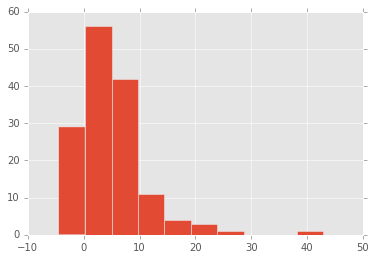

In [18]:
df['Change'].hist()

It looks like most cities saw a population change between 0 and 10%. We saw from the data above that Toronto itself gained 9.2%. One city happened to gain over 40%, and a few cities lost from 0 to 5%.

#### Exercise 1

Head to this [webpage](http://www.fda.gov/Safety/Recalls/ArchiveRecalls/2015/default.htm) with a list of FDA recalls. Write the code to collect the data in this table. *Note*: Due to weird formatting in the HTML, this doesn't quite work as expected.

### Screen scraping in unstructured format

Much of the data we'll want to collect will be in a table format. But much of the time, what we want won't be in a table format. There's been a bit of turn away from using tables in web development in the past 10-15 years. Because of that, we will need to dig a little more into the guts of the HTML to extract what we want.

Let's say we're pricing out hockey helmets for ourselves or our relatives for the holidays (many roller derby players actually do wear hockey helmets). We could check out a popular hockey website to see what kinds of helmets are available.

We start off like we did with the table. But here, we try to find the unit which contains each unit we want to collect data on. In this case, it looks like each helmet is in a <code>&lt;li&gt;</code> (or list) element. For the record, the elements we're typically looking for are containers which can hold other elements, which include <code>li, p, div, span,</code> and any of the header elements -- <code>h1, h2, h3, h4, h5, h6</code>.

We also see that each of these elements has the class <code>item</code>. So it seems like a good guess that if we get all the list items, then we'll be on the right track.

![](img/hockey-site.png)

In [85]:
url = "http://www.hockeymonkey.com/equipment/helmets/helmets.html"
res = urllib.request.urlopen(url)

html = res.read()

bs = BeautifulSoup(html, "html.parser")

In [86]:
items = bs.find_all("li", "item")

From there, we have to find how to get the helmet name and the price. Upon further inspect, it looks like the element which contains name is an <code>h2</code> element with class <code>product-name</code>. Price is conained in a <code>span</code> element with class <code>price</code>.

![](img/hockey-name.png)

![](img/hockey-price.png)

From there, we can loop through all the items in the list and store the name and price in their own variables.

In [90]:
data = []
for item in items:
    name = item.find("h2", "product-name")
    name = name.text
    
    price = item.find("span", "price")
    price = price.text
    
    dt = (name, price)
    data.append(dt)

And from there, we can store all these data into a DataFrame again.

In [ ]:
df = pd.DataFrame(data, columns = ['Name', 'Price'])

Like the transformation above, we can convert the price to a float and take the mean, once we remove the dollar sign from the text.

In [95]:
df['Price'] = df['Price'].str.replace('$', '')
df['Price'] = df['Price'].astype(np.float64)
df['Price'].mean()

233.48999999999987

#### Exercise 2

Look at this [name website](http://www.behindthename.com/names/usage/english). Collect the name, the gender, the linguistic origin, and the description.

In [20]:
url = "http://www.behindthename.com/names/usage/english"
res = urllib.request.urlopen(url)

html = res.read()

bs = BeautifulSoup(html, "html.parser")

In [21]:
items = bs.find_all("div", "browsename")

In [23]:
data = []
for item in items:
    name = item.find("a")
    name = name.text
    
    gender_list = []
    masc = item.find("span", "masc")
    fem  = item.find("span", "fem")

    if masc:
        gender_list.append('M')
    if fem:
        gender_list.append('F')
        
    gender = ' & '.join(gender_list)
    
    desc = item.find("span", "info")
    desc = desc.text
    
    dt = (name, gender, desc)
    data.append(dt)
    
data

[('AALIYAH', 'F', 'Arabic, English (Modern)'),
 ('AAREN', 'M & F', ' & '),
 ('AARON', 'M', 'English, Jewish, Biblical, Biblical Latin, Biblical Greek'),
 ('ABBEY', 'F', 'English'),
 ('ABBI', 'F', 'English'),
 ('ABBIE', 'F', 'English'),
 ('ABBY', 'F', 'English'),
 ('ABE  (1)', 'M', 'English, Jewish'),
 ('ABEGAIL', 'F', 'English (Rare)'),
 ('ABEL',
  'M',
  'English, French, Spanish, Portuguese, Georgian, Biblical, Biblical Latin, Biblical Greek'),
 ('ABIGAIL', 'F', 'English, German, Biblical, Biblical Latin'),
 ('ABIGAYLE', 'F', 'English (Modern)'),
 ('ABNER', 'M', 'English, Biblical, Biblical Latin'),
 ('ABRAHAM',
  'M',
  'English, Hebrew, Spanish, French, Dutch, German, Swedish, Norwegian, Danish, Biblical, Biblical Latin'),
 ('ABRAM  (1)', 'M', 'English, Biblical'),
 ('ACACIA', 'F', 'English (Rare)'),
 ('ACE  (1)', 'M', 'English'),
 ('ADA', 'F', 'English, German, Polish, Hungarian, Italian, Finnish'),
 ('ADAIR', 'M', 'English (Rare)'),
 ('ADALYN', 'F', 'English (Modern)'),
 ('ADALYN